# Imports

In [1]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 150)
import matplotlib.pyplot as plt

from nltk.probability import FreqDist
from stop_words import get_stop_words
stop_words = get_stop_words('bulgarian')

import classla
# classla.download('bg')

In [2]:
DATA_PATH_PREP = '../DATA/prepared'

# Load data

In [3]:
df_samples = pd.read_pickle(f'{DATA_PATH_PREP}/03_df_samples.pkl')
print(df_samples.shape)
df_samples.head()

(600, 2)


,text,author
0,"сията й — злато с шепа, моля ти се. Късмет ли да го наречеш, какво да го наречеш — не знайш! Па вземи и децата й: по-голямото, не го ли знаете, ед...",aleko-konstantinov
1,сега не си раз,aleko-konstantinov
2,"ме какво да правя.\n\t— Как какво да правиш! Прави каквото правят хората: свий си опашката, па си налягай парцалите… Какво се кикотиш, не е ли тъй...",aleko-konstantinov
3,"а, че не съчувствувай на македонците…\n\t(Я тури две-три дървета в печката. Стига.)\n\tНямаше си хас, джанъм, този Биконсфилд, дето ни разпокъса. ...",aleko-konstantinov
4,"шва)… значи, и да се разгатне енигмата на зеленото сукно с металическото копче, и пламъкът на петрола в нощната тъмнина, и ужасният смрад, и цвърт...",aleko-konstantinov


## Character-based lexical features

The number of each distinct special character, spaces, punctuation, parentheses and quotation marks as separate features.

In [4]:
tmp_text = df_samples['text'][4]
tmp_text[:250]

'шва)… значи, и да се разгатне енигмата на зеленото сукно с металическото копче, и пламъкът на петрола в нощната тъмнина, и ужасният смрад, и цвъртението… и закритият фаетон в Драгоманското дефиле, и всичко, и всичко… У-у! Косите ми настръхват… Но, ба'

In [5]:
format_specific = ''.join({char for char in tmp_text if not char.isalnum() and char not in string.punctuation and char not in {'\t', '\n'}})
print(f'{format_specific=}')

special = string.punctuation + format_specific + '=#<> '
special

format_specific=' —…'


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ —…=#<> '

In [6]:
def count_characters(string):
    return {char: string.count(char) for char in special}

char_counts = df_samples['text'].apply(count_characters)
char_counts[:3]

0    {'!': 2, '"': 0, '#': 0, '$': 0, '%': 0, '&': 0, ''': 0, '(': 0, ')': 0, '*': 0, '+': 0, ',': 27, '-': 1, '.': 3, '/': 0, ':': 2, ';': 0, '<': 0, ...
1    {'!': 0, '"': 0, '#': 0, '$': 0, '%': 0, '&': 0, ''': 0, '(': 0, ')': 0, '*': 0, '+': 0, ',': 0, '-': 0, '.': 0, '/': 0, ':': 0, ';': 0, '<': 0, '...
2    {'!': 1, '"': 0, '#': 0, '$': 0, '%': 0, '&': 0, ''': 0, '(': 1, ')': 1, '*': 0, '+': 0, ',': 14, '-': 5, '.': 6, '/': 0, ':': 1, ';': 0, '<': 0, ...
Name: text, dtype: object

In [7]:
text_features = pd.DataFrame.from_records(char_counts)
text_features

,!,"""",#,$,%,&,',(,),*,...,^,_,`,{,|,},~,,—,…
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,138,5,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
2,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,123,7,9
3,0,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,137,1,3
4,5,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,142,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,81,0,0
596,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,170,7,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,89,0,0
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,52,0,0


In [8]:
only_zeros = text_features.columns[(text_features == 0).all()].tolist()
print(f'{only_zeros=}')
print(f'{len(only_zeros)=}')

text_features = text_features.drop(only_zeros, axis=1)
text_features

only_zeros=['"', '#', '$', '%', '&', "'", '+', '/', '<', '=', '>', '@', '\\', '^', '`', '{', '|', '}', '~']
len(only_zeros)=19


,!,(,),*,",",-,.,:,;,?,[,],_,,—,…
0,2,0,0,0,27,1,3,2,0,0,0,0,0,138,5,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
2,1,1,1,0,14,5,6,1,0,2,0,0,0,123,7,9
3,0,2,1,0,20,4,8,2,0,1,0,0,0,137,1,3
4,5,0,1,0,18,3,2,0,0,0,0,0,0,142,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,0,0,0,81,0,0
596,4,0,0,0,12,1,7,3,0,0,0,0,0,170,7,0
597,0,0,0,0,5,1,3,1,0,0,0,0,0,89,0,0
598,0,0,0,0,5,1,2,1,0,3,0,0,0,52,0,0


## EDA: Compare frequencies

In [9]:
text_features['author'] = df_samples['author']
text_features

,!,(,),*,",",-,.,:,;,?,[,],_,,—,…,author
0,2,0,0,0,27,1,3,2,0,0,0,0,0,138,5,0,aleko-konstantinov
1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,aleko-konstantinov
2,1,1,1,0,14,5,6,1,0,2,0,0,0,123,7,9,aleko-konstantinov
3,0,2,1,0,20,4,8,2,0,1,0,0,0,137,1,3,aleko-konstantinov
4,5,0,1,0,18,3,2,0,0,0,0,0,0,142,1,9,aleko-konstantinov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,0,0,0,81,0,0,jordan-jovkov
596,4,0,0,0,12,1,7,3,0,0,0,0,0,170,7,0,jordan-jovkov
597,0,0,0,0,5,1,3,1,0,0,0,0,0,89,0,0,jordan-jovkov
598,0,0,0,0,5,1,2,1,0,3,0,0,0,52,0,0,jordan-jovkov


In [10]:
df_punct_grouped = text_features.groupby('author').mean().reset_index()
df_punct_grouped

,author,!,(,),*,",",-,.,:,;,?,[,],_,,—,…
0,aleko-konstantinov,1.77,0.18,0.20,0.00,11.23,1.42,3.82,0.58,0.38,0.95,0.00,0.00,0.04,92.31,2.71,1.66
1,dimityr-dimov,0.39,0.00,0.00,0.00,6.81,0.33,5.60,0.10,0.00,0.58,0.00,0.00,0.00,87.29,3.01,0.50
2,dimityr-talev,0.51,0.05,0.05,0.10,9.49,0.46,4.64,0.26,0.12,0.36,0.05,0.05,0.00,89.25,2.77,0.58
3,elin-pelin,0.92,0.00,0.00,0.00,9.57,0.46,5.54,0.40,0.00,0.03,0.00,0.00,0.00,91.04,1.69,0.22
4,ivan_vazov,0.70,0.17,0.16,0.25,10.37,0.61,3.78,1.04,0.51,0.97,0.08,0.08,0.02,86.17,3.71,0.60
5,jordan-jovkov,0.33,0.00,0.00,0.00,9.01,0.79,4.07,0.30,0.05,0.26,0.00,0.00,0.00,87.54,1.07,0.00


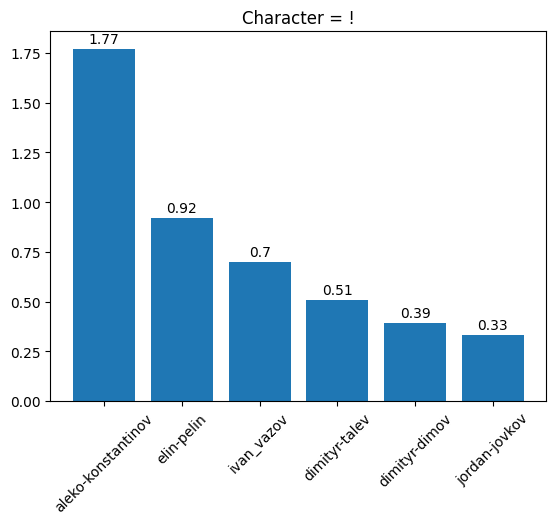

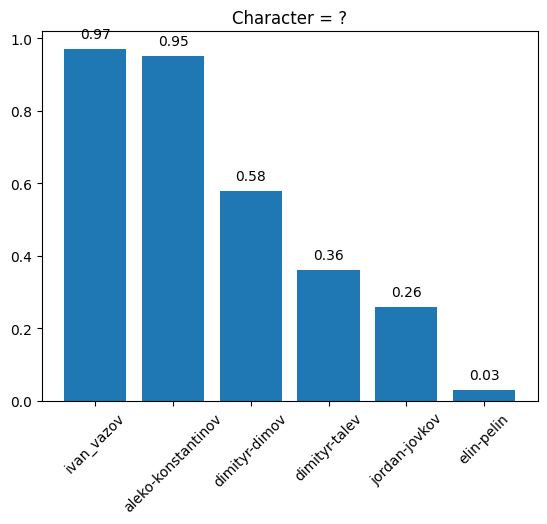

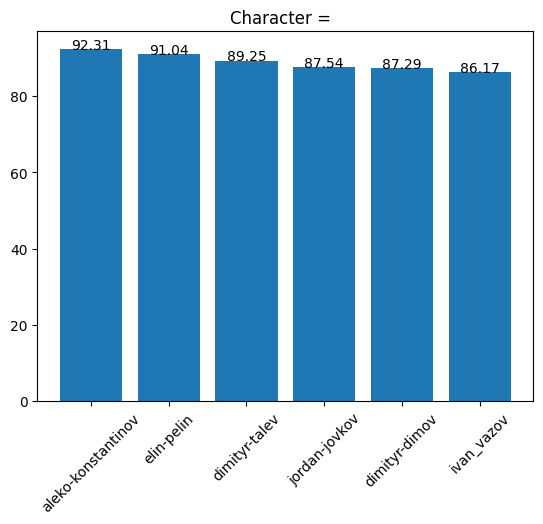

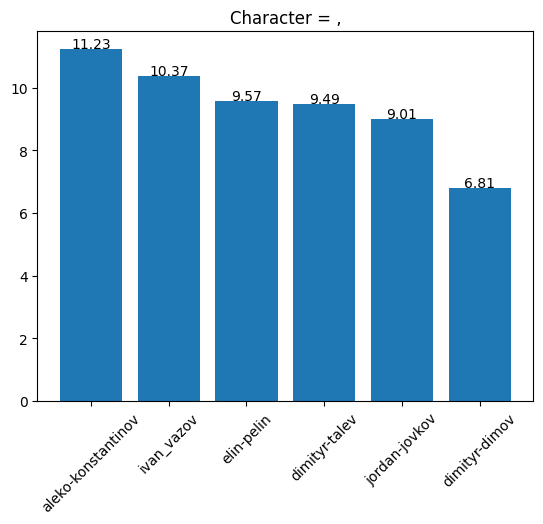

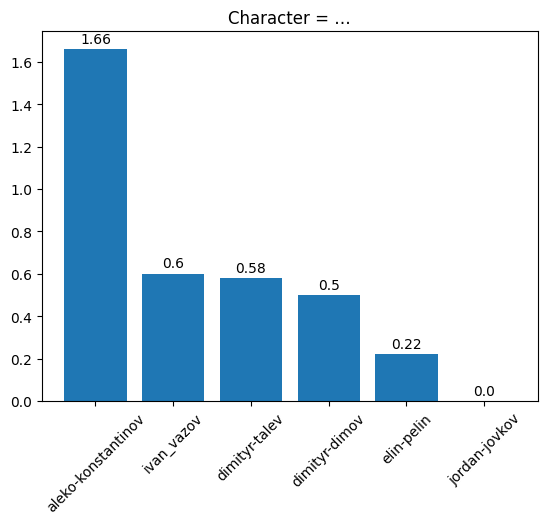

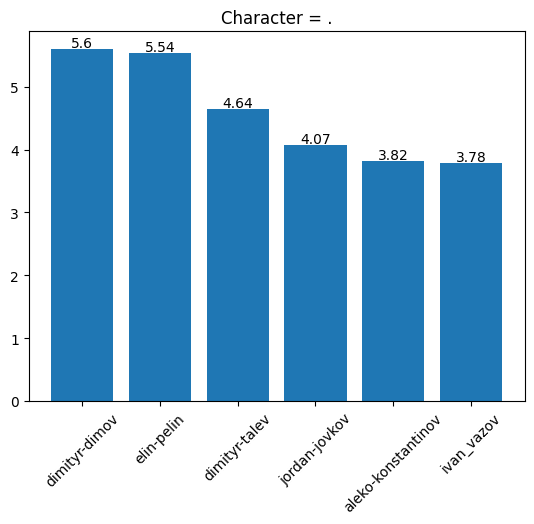

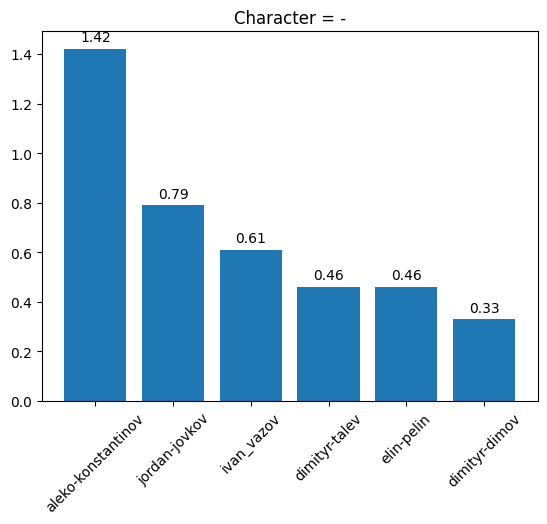

In [11]:
interesting = ['!', '?', ' ', ',', '…', '.', '-']

for inter in interesting:
    sorted_df = df_punct_grouped.sort_values(by=inter, ascending=False)
    y = sorted_df[inter]

    for i, v in enumerate(y):
        plt.text(i, v + 0.03, str(v), ha='center')
    
    plt.title(f'Character = {inter}')
    plt.xticks(rotation=45)
    plt.bar(sorted_df['author'], y);
    plt.show()

## Sentence- and word-based features

Distribution of POS-tags, token length, sentence length, average word length, words in all-caps and counts of words above and below 2-3 and 6 characters as separate features.

In [12]:
nlp = classla.Pipeline('bg', processors='tokenize,pos')
doc = nlp("Алеко Константинов е роден в Свищов. Кой е Иван Вазов?")
print(doc.to_conll())

2023-02-05 19:46:53 INFO: Loading these models for language: bg (Bulgarian):
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |

2023-02-05 19:46:53 INFO: Use device: cpu
2023-02-05 19:46:53 INFO: Loading: tokenize
2023-02-05 19:46:53 INFO: Loading: pos
2023-02-05 19:46:55 INFO: Done loading processors!


# newpar id = 1
# sent_id = 1.1
# text = Алеко Константинов е роден в Свищов.
1	Алеко	_	PROPN	Npmsi	Definite=Ind|Gender=Masc|Number=Sing	_	_	_	_
2	Константинов	_	PROPN	Hmsi	Definite=Ind|Gender=Masc|Number=Sing	_	_	_	_
3	е	_	AUX	Vxitf-r3s	Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act	_	_	_	_
4	роден	_	VERB	Vpptcv--smi	Aspect=Perf|Definite=Ind|Gender=Masc|Number=Sing|VerbForm=Part|Voice=Pass	_	_	_	_
5	в	_	ADP	R	_	_	_	_	_
6	Свищов	_	PROPN	Npmsi	Definite=Ind|Gender=Masc|Number=Sing	_	_	_	SpaceAfter=No
7	.	_	PUNCT	punct	_	_	_	_	_

# sent_id = 1.2
# text = Кой е Иван Вазов?
1	Кой	_	PRON	Pie-os-m	Case=Nom|Gender=Masc|Number=Sing|PronType=Int	_	_	_	_
2	е	_	AUX	Vxitf-r3s	Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act	_	_	_	_
3	Иван	_	PROPN	Npmsi	Definite=Ind|Gender=Masc|Number=Sing	_	_	_	_
4	Вазов	_	PROPN	Hmsi	Definite=Ind|Gender=Masc|Number=Sing	_	_	_	SpaceAfter=No
5	?	_	PUNCT	punct	_	_	_	_	_




In [13]:
pos_tags = []
print(doc.to_dict()[0])

for parsed_info, _ in doc.to_dict():
    for entry in parsed_info:
        pos_tags.append(entry['upos'])
        print(f"{entry['text'].rjust(15)} | {entry['upos'].rjust(5)} | {entry['xpos']}")
    print()

tag_counts = Counter(pos_tags)
tag_distribution = {tag: count / len(pos_tags) for tag, count in tag_counts.items()}

print(f'{pos_tags=}')
print(f'{tag_distribution=}')
print(pd.Series(tag_distribution))

([{'id': 1, 'text': 'Алеко', 'upos': 'PROPN', 'xpos': 'Npmsi', 'feats': 'Definite=Ind|Gender=Masc|Number=Sing'}, {'id': 2, 'text': 'Константинов', 'upos': 'PROPN', 'xpos': 'Hmsi', 'feats': 'Definite=Ind|Gender=Masc|Number=Sing'}, {'id': 3, 'text': 'е', 'upos': 'AUX', 'xpos': 'Vxitf-r3s', 'feats': 'Aspect=Imp|Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act'}, {'id': 4, 'text': 'роден', 'upos': 'VERB', 'xpos': 'Vpptcv--smi', 'feats': 'Aspect=Perf|Definite=Ind|Gender=Masc|Number=Sing|VerbForm=Part|Voice=Pass'}, {'id': 5, 'text': 'в', 'upos': 'ADP', 'xpos': 'R'}, {'id': 6, 'text': 'Свищов', 'upos': 'PROPN', 'xpos': 'Npmsi', 'feats': 'Definite=Ind|Gender=Masc|Number=Sing', 'misc': 'SpaceAfter=No'}, {'id': 7, 'text': '.', 'upos': 'PUNCT', 'xpos': 'punct'}], '# newpar id = 1\n# sent_id = 1.1\n# text = Алеко Константинов е роден в Свищов.\n')
          Алеко | PROPN | Npmsi
   Константинов | PROPN | Hmsi
              е |   AUX | Vxitf-r3s
          роден |  VERB | Vpptcv--smi


### Distribution of POS-tags

What is the percentage of each POS tag?

What some of the abbreviations mean:
- `ADP` - Adposition;
- `PART` - Particle;
- `AUX` - Auxiliary; 
- `DET` - Determiner;
- `CCONJ` - Coordinating Conjunction;
- `SCONJ` - Subordinating Conjunction;

In [14]:
pos_meaning = {
    'NOUN': 'съществителни',
    'PRON': 'местоимения',
    'PUNCT': 'пунктуация',
    'ADP': 'адпозиция', # на, пред, зад, до, ...
    'VERB': 'глаголи',
    'PART': 'частици', # ли, де, бе, ма, бре, ...
    'AUX': 'спомагателни', # съм, ще, да, ...;
    'DET': 'определителни', # един, всички, ...
    'CCONJ': 'съгласуващ съюз', # и, но, или, ...
    'ADJ': 'прилагателни',
    'INTJ': 'междуметия', # а, у, охо, ...
    'SCONJ': 'подчинителен съюз', # след, защото, ако, докато, ...
    'ADV': 'наречия',
    'PROPN': 'предлози', # за, над, между, ...
    'NUM': 'числови',
    'X': 'не може да се определи',
}

In [15]:
def gen_pos_tags(text: str):
    tokenized = nlp(text).to_dict()
    parsed_infos = sum([parsed_info for parsed_info, _ in tokenized], [])
    pos_tags = [entry['upos'] for entry in parsed_infos]

    tag_counts = Counter(pos_tags)
    total_tags = len(pos_tags)
    tag_distribution = {tag: count / total_tags
                        for tag, count in tag_counts.items()}

    return pd.Series(tag_distribution)

# text = "Алеко Константинов е роден в Свищов. Кой е Иван Вазов?"
# gen_pos_tags(text)

df_tags = df_samples['text'].apply(gen_pos_tags)
df_tags

,NOUN,PRON,PUNCT,ADP,VERB,PART,AUX,DET,CCONJ,ADJ,INTJ,SCONJ,ADV,PROPN,NUM,X
0,0.109195,0.155172,0.224138,0.045977,0.155172,0.063218,0.034483,0.051724,0.051724,0.045977,0.017241,0.022989,0.022989,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN
2,0.072289,0.156627,0.253012,0.024096,0.198795,0.036145,0.072289,0.024096,0.036145,0.012048,0.018072,0.018072,0.066265,0.006024,0.006024,NaN
3,0.084746,0.118644,0.214689,0.056497,0.192090,0.039548,0.056497,0.028249,0.039548,0.028249,0.005650,0.033898,0.039548,0.033898,0.028249,NaN
4,0.211111,0.055556,0.200000,0.094444,0.105556,0.011111,0.066667,0.011111,0.061111,0.077778,0.033333,0.011111,0.055556,NaN,0.005556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.197917,0.062500,0.145833,0.093750,0.114583,0.010417,0.041667,0.031250,0.093750,0.083333,0.020833,0.010417,0.072917,0.020833,NaN,NaN
596,0.183168,0.158416,0.163366,0.113861,0.099010,0.004950,0.034653,0.029703,0.044554,0.074257,0.009901,NaN,0.059406,0.024752,NaN,NaN
597,0.181818,0.090909,0.090909,0.101010,0.151515,0.020202,0.040404,0.040404,0.101010,0.101010,NaN,0.010101,0.030303,0.040404,NaN,NaN
598,0.166667,0.045455,0.196970,0.136364,0.045455,0.015152,0.030303,0.030303,0.090909,0.090909,NaN,NaN,0.060606,0.075758,0.015152,NaN


In [16]:
df_tags = df_tags.fillna(0)
df_tags

,NOUN,PRON,PUNCT,ADP,VERB,PART,AUX,DET,CCONJ,ADJ,INTJ,SCONJ,ADV,PROPN,NUM,X
0,0.109195,0.155172,0.224138,0.045977,0.155172,0.063218,0.034483,0.051724,0.051724,0.045977,0.017241,0.022989,0.022989,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0
2,0.072289,0.156627,0.253012,0.024096,0.198795,0.036145,0.072289,0.024096,0.036145,0.012048,0.018072,0.018072,0.066265,0.006024,0.006024,0.0
3,0.084746,0.118644,0.214689,0.056497,0.192090,0.039548,0.056497,0.028249,0.039548,0.028249,0.005650,0.033898,0.039548,0.033898,0.028249,0.0
4,0.211111,0.055556,0.200000,0.094444,0.105556,0.011111,0.066667,0.011111,0.061111,0.077778,0.033333,0.011111,0.055556,0.000000,0.005556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.197917,0.062500,0.145833,0.093750,0.114583,0.010417,0.041667,0.031250,0.093750,0.083333,0.020833,0.010417,0.072917,0.020833,0.000000,0.0
596,0.183168,0.158416,0.163366,0.113861,0.099010,0.004950,0.034653,0.029703,0.044554,0.074257,0.009901,0.000000,0.059406,0.024752,0.000000,0.0
597,0.181818,0.090909,0.090909,0.101010,0.151515,0.020202,0.040404,0.040404,0.101010,0.101010,0.000000,0.010101,0.030303,0.040404,0.000000,0.0
598,0.166667,0.045455,0.196970,0.136364,0.045455,0.015152,0.030303,0.030303,0.090909,0.090909,0.000000,0.000000,0.060606,0.075758,0.015152,0.0


#### EDA: Compare frequencies

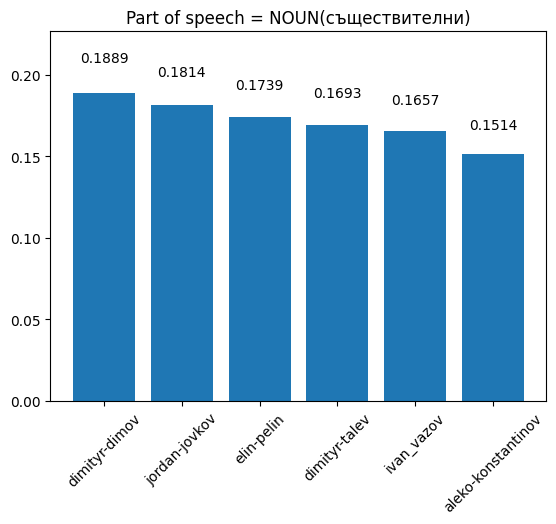

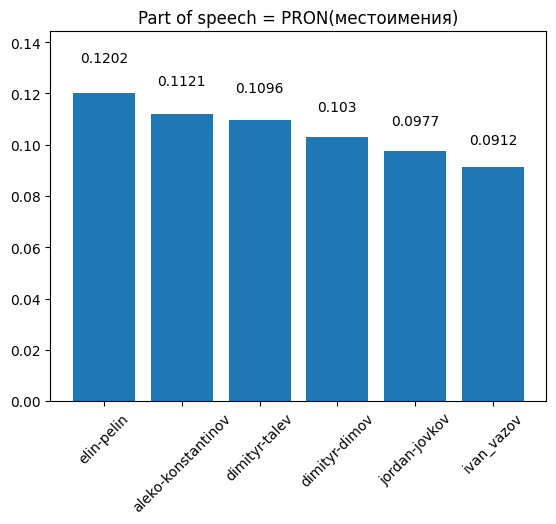

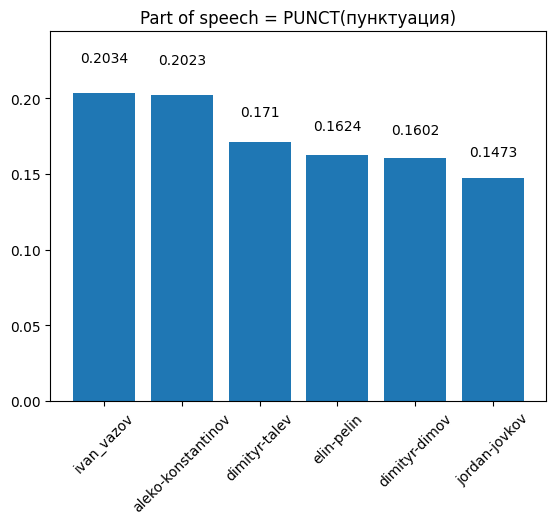

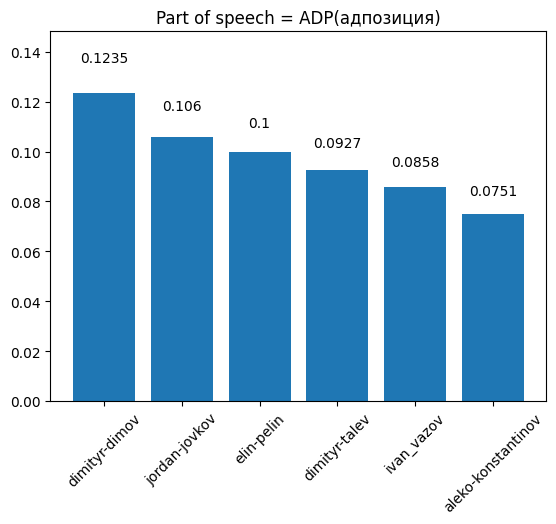

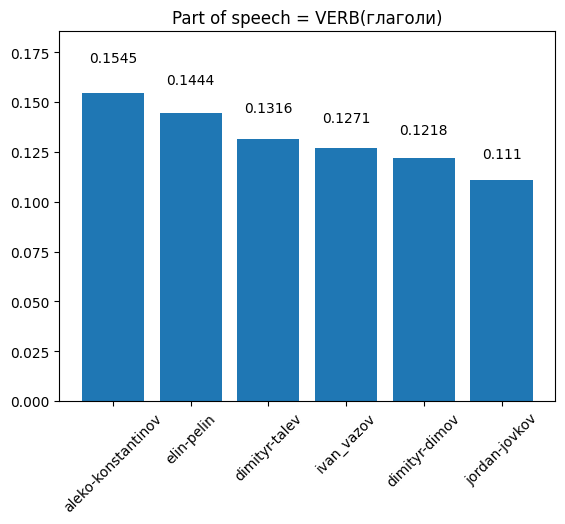

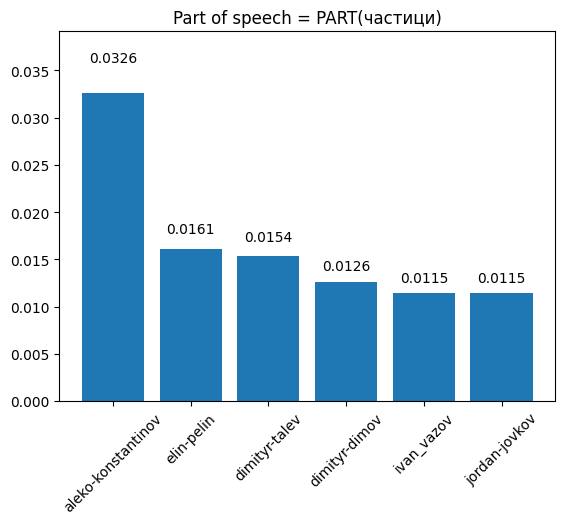

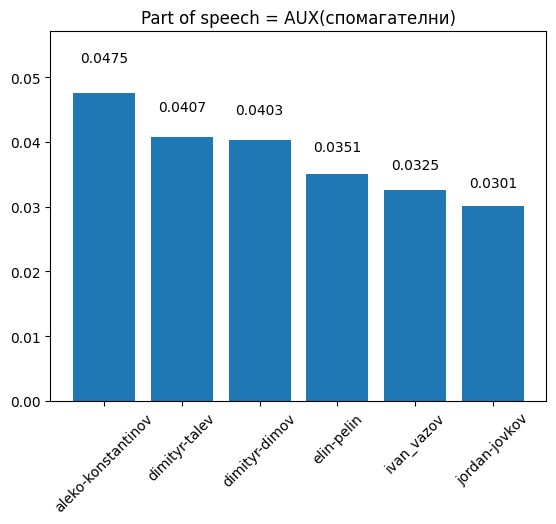

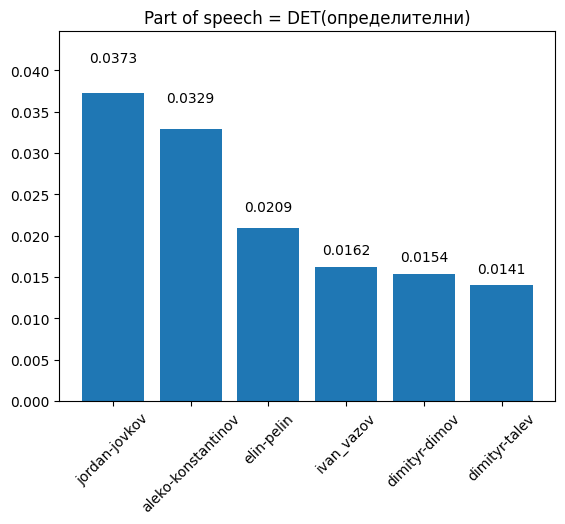

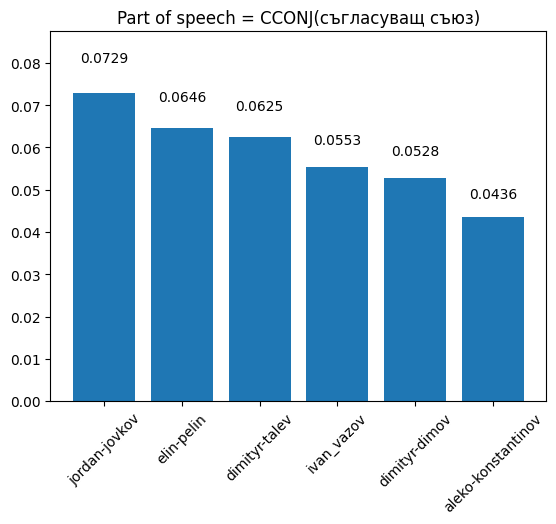

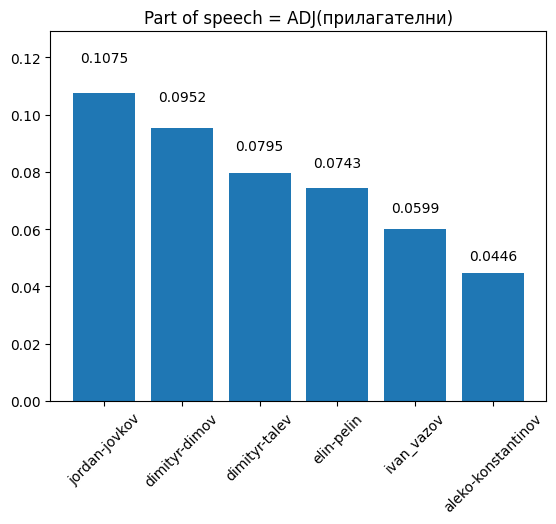

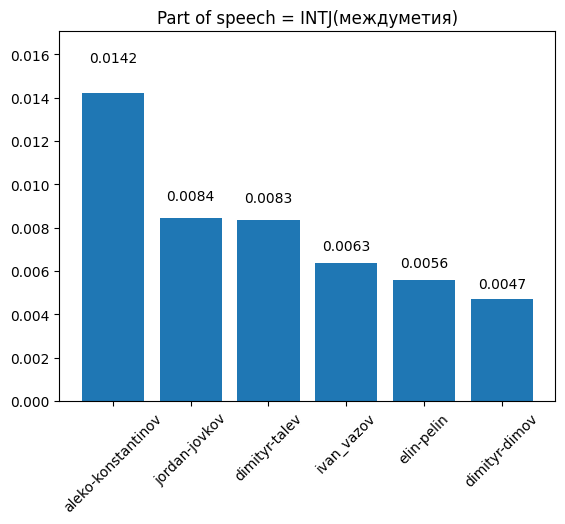

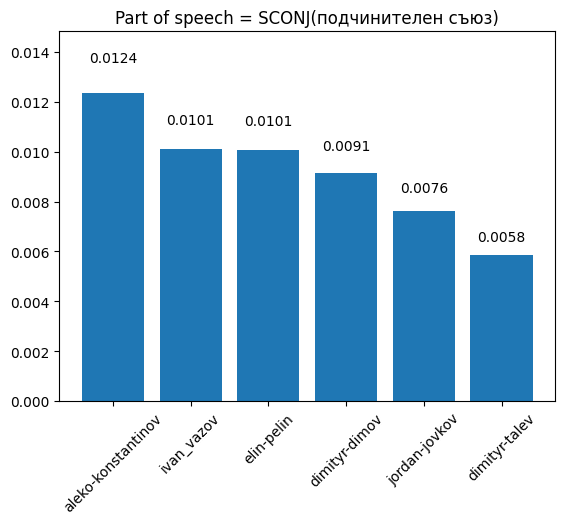

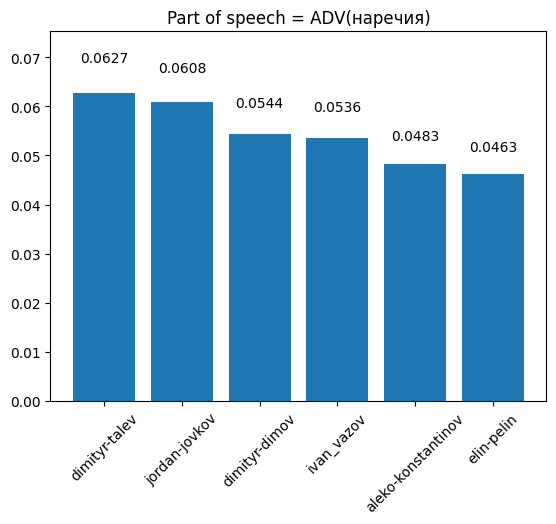

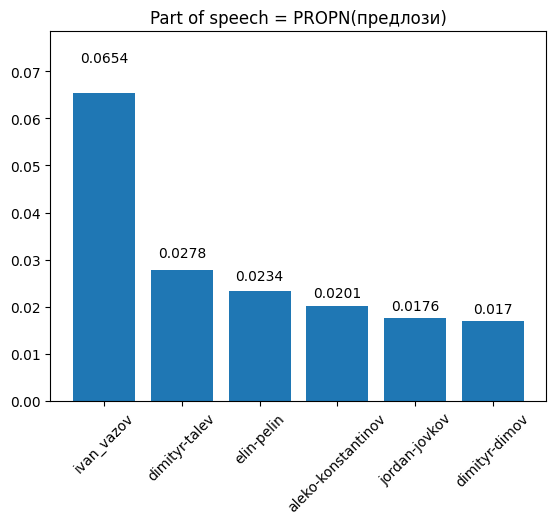

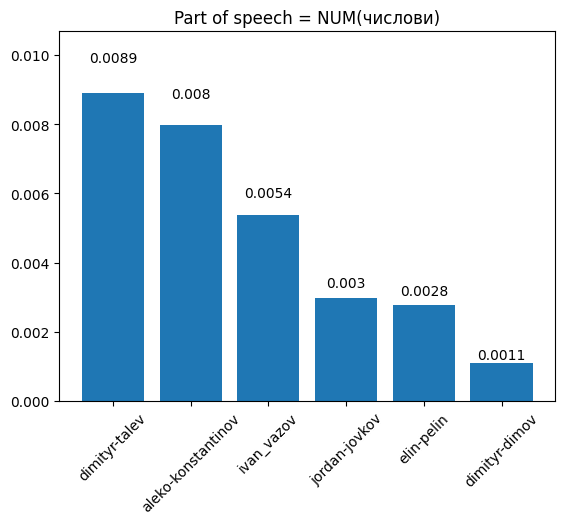

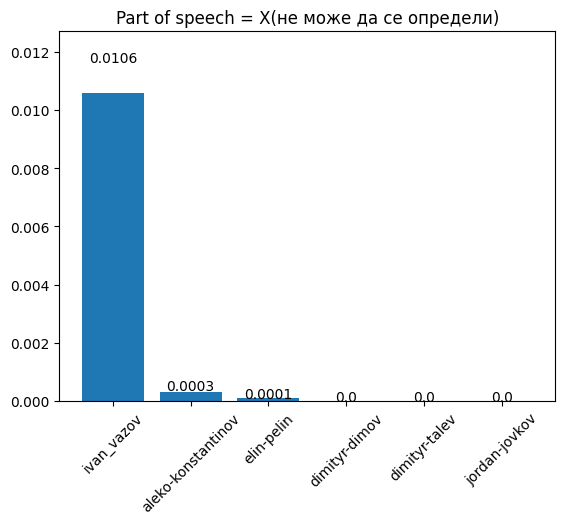

In [17]:
df_tags['author'] = df_samples['author']
df_tags_grouped = df_tags.groupby('author').mean().reset_index()
df_tags_grouped

interesting = df_tags_grouped.columns[1:]

for inter in interesting:
    sorted_df = df_tags_grouped.sort_values(by=inter, ascending=False)
    y = sorted_df[inter]
    ax = plt.gca()
    ax.set_ylim([0, y.max() * 1.2])

    for i, v in enumerate(y):
        plt.text(i, v * 1.1, str(round(v, 4)), ha='center')
    
    plt.title(f'Part of speech = {inter}({pos_meaning.get(inter)})')
    plt.xticks(rotation=45)
    plt.bar(sorted_df['author'], y);
    plt.show()
    
df_tags = df_tags.drop('author', axis=1)

#### Combine with main dataframe

In [18]:
text_features = pd.concat([text_features, df_tags], axis=1)
text_features

,!,(,),*,",",-,.,:,;,?,...,AUX,DET,CCONJ,ADJ,INTJ,SCONJ,ADV,PROPN,NUM,X
0,2,0,0,0,27,1,3,2,0,0,...,0.034483,0.051724,0.051724,0.045977,0.017241,0.022989,0.022989,0.000000,0.000000,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0
2,1,1,1,0,14,5,6,1,0,2,...,0.072289,0.024096,0.036145,0.012048,0.018072,0.018072,0.066265,0.006024,0.006024,0.0
3,0,2,1,0,20,4,8,2,0,1,...,0.056497,0.028249,0.039548,0.028249,0.005650,0.033898,0.039548,0.033898,0.028249,0.0
4,5,0,1,0,18,3,2,0,0,0,...,0.066667,0.011111,0.061111,0.077778,0.033333,0.011111,0.055556,0.000000,0.005556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.041667,0.031250,0.093750,0.083333,0.020833,0.010417,0.072917,0.020833,0.000000,0.0
596,4,0,0,0,12,1,7,3,0,0,...,0.034653,0.029703,0.044554,0.074257,0.009901,0.000000,0.059406,0.024752,0.000000,0.0
597,0,0,0,0,5,1,3,1,0,0,...,0.040404,0.040404,0.101010,0.101010,0.000000,0.010101,0.030303,0.040404,0.000000,0.0
598,0,0,0,0,5,1,2,1,0,3,...,0.030303,0.030303,0.090909,0.090909,0.000000,0.000000,0.060606,0.075758,0.015152,0.0


### Distribution of Token Length

What is the percentage of each token length?

In [19]:
def distrib_tokens(text: str):
    tokenized = nlp(text).to_dict()
    parsed_infos = sum([parsed_info for parsed_info, _ in tokenized], [])
    
    token_distribution = Counter([len(entry['text']) for entry in parsed_infos])
    total_tokens = len(token_distribution)
    token_distribution = {length: frequency / total_tokens
                          for length, frequency in token_distribution.items()}
    
    return pd.Series(token_distribution)

# text = "Алеко Константинов е роден в Свищов. Кой е Иван Вазов?"
# distrib_tokens(text)

df_tokens = df_samples['text'].apply(distrib_tokens)
df_tokens = df_tokens.fillna(0)
df_tokens

,5,1,4,2,6,7,11,9,8,3,...,13,15,21,19,25,17,26,18,16,24
0,1.600000,5.000000,1.500000,5.000000,1.400000,0.500000,0.100000,0.700000,0.300000,1.300000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.363636,4.545455,1.000000,4.181818,1.000000,1.000000,0.000000,0.181818,0.454545,0.909091,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.153846,4.153846,1.307692,2.692308,0.769231,0.692308,0.153846,0.384615,0.538462,1.384615,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.538462,4.230769,0.692308,2.384615,1.538462,1.000000,0.230769,0.461538,0.846154,0.384615,...,0.153846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.583333,2.250000,0.500000,1.166667,1.083333,0.750000,0.000000,0.500000,0.333333,0.500000,...,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,1.307692,4.615385,1.153846,2.615385,1.538462,2.384615,0.076923,0.000000,0.538462,0.692308,...,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.769231,1.692308,0.923077,1.153846,0.384615,0.923077,0.153846,0.307692,0.769231,0.307692,...,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.636364,1.727273,0.363636,1.090909,0.272727,0.818182,0.090909,0.090909,0.363636,0.454545,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
text_features = pd.concat([text_features, df_tokens], axis=1)
text_features

,!,(,),*,",",-,.,:,;,?,...,13,15,21,19,25,17,26,18,16,24
0,2,0,0,0,27,1,3,2,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,14,5,6,1,0,2,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,1,0,20,4,8,2,0,1,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,1,0,18,3,2,0,0,0,...,0.153846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,4,0,0,0,12,1,7,3,0,0,...,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0,0,0,0,5,1,3,1,0,0,...,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0,0,0,0,5,1,2,1,0,3,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Distribution of Sentence Length

What is the percentage of sentence length per text?

In [21]:
def sentence_distribution(text):
    tokenized = nlp(text).to_dict()
    sentence_lengths = [len(sent.split('=')[-1].strip()) for _, sent in tokenized]
    
    length_counts = Counter(sentence_lengths)
    total_sentences = len(sentence_lengths)
    distribution = {length: frequency / total_sentences
                    for length, frequency in length_counts.items()}
    
    return pd.Series(distribution)

# text = "Алеко Константинов е роден в Свищов. Кой е Иван Вазов?"
# sentence_distribution(text)

df_sent_lens = df_samples['text'].apply(sentence_distribution)
df_sent_lens = df_sent_lens.fillna(0)
df_sent_lens

,35,56,232,147,136,74,14,18,22,71,...,224,181,292,383,294,548,356,320,282,247
0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.000000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.062500,0.125,0.0625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.076923,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
text_features = pd.concat([text_features, df_sent_lens], axis=1)
text_features

,!,(,),*,",",-,.,:,;,?,...,224,181,292,383,294,548,356,320,282,247
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Average Word Length

In [23]:
def average_word_length(text):
    words = text.split()
    total_length = sum([len(word) for word in words])
    average_length = total_length / len(words)
    return average_length

# text = "Алеко Константинов е роден в Свищов. Кой е Иван Вазов?"
# average_word_length(text)

avg_word_len = df_samples['text'].apply(average_word_length)
text_features['avg_word_len'] = avg_word_len
text_features

,!,(,),*,",",-,.,:,;,?,...,181,292,383,294,548,356,320,282,247,avg_word_len
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.900000
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.152672
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.478571
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.951220
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517045
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.011111
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.754717


### Words in all-caps

In [24]:
def percent_all_caps(text):
    words = text.split()
    all_caps_words = [word for word in words if word.isupper()]
    percent = len(all_caps_words) / len(words)
    return percent

perc_all_caps = df_samples['text'].apply(percent_all_caps)
text_features['perc_all_caps'] = perc_all_caps
text_features

,!,(,),*,",",-,.,:,;,?,...,292,383,294,548,356,320,282,247,avg_word_len,perc_all_caps
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.900000,0.007143
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,0.000000
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.152672,0.030534
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.478571,0.007143
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.083333,0.013889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.951220,0.000000
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517045,0.000000
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.011111,0.000000
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.754717,0.075472


### Counts of words above and below 2-3 and 6 characters

In [25]:
def token_len_below(text, n):
    words = text.split()
    num_tokens_below = [word for word in words if len(word) < n]
    count = len(num_tokens_below)
    return count

below2 = df_samples['text'].apply(lambda text: token_len_below(text, 2))
below3 = df_samples['text'].apply(lambda text: token_len_below(text, 3))
below6 = df_samples['text'].apply(lambda text: token_len_below(text, 6))

text_features['below2'] = below2
text_features['below3'] = below3
text_features['below6'] = below6
text_features

,!,(,),*,",",-,.,:,;,?,...,548,356,320,282,247,avg_word_len,perc_all_caps,below2,below3,below6
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,3.900000,0.007143,15,59,103
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,2.750000,0.000000,0,2,4
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,4.152672,0.030534,15,56,94
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,4.478571,0.007143,13,50,99
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,5.083333,0.013889,18,49,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,4.951220,0.000000,13,26,43
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,4.517045,0.000000,31,64,107
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,5.011111,0.000000,13,28,52
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,4.754717,0.075472,5,18,32


## Function words

The frequency of each function word is counted and used as a separate feature.

In [26]:
def function_word_frequency(text: str):
    tokens = text.split()
    function_words = [token for token in tokens if token in stop_words]
    fdist = FreqDist(function_words)
    return pd.Series(dict(fdist), dtype=int)

# text = "Алеко Константинов е роден в Свищов. Кой е Иван Вазов?"
# function_word_frequency(text)

df_func_words = df_samples['text'].apply(function_word_frequency)
df_func_words = df_func_words.fillna(0)
df_func_words

,й,с,моля,ти,ли,да,го,какво,не,и,...,била,обаче,взема,двама,били,според,новина,напред,ч,първо
0,1.0,1.0,2.0,2.0,4.0,3.0,3.0,1.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,4.0,2.0,6.0,1.0,3.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,1.0,2.0,1.0,7.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,7.0,1.0,0.0,1.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,3.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
text_features = pd.concat([text_features, df_func_words], axis=1)
text_features

,!,(,),*,",",-,.,:,;,?,...,била,обаче,взема,двама,били,според,новина,напред,ч,първо
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Readability indexes obtained

### Flesch Reading Ease Score

In [28]:
def count_syllables(word):
    vowels = 'аъоуеиАЪОУЕИ'
    syllables = 0
    for i in range(len(word)):
        if word[i] in vowels and (i == 0 or word[i-1] not in vowels):
            syllables += 1
    return syllables

def flesch_reading_ease(text):
    words = text.split()
    num_words = len(words)
    num_sentences = text.count('.') + text.count('!') + text.count('?')
    num_syllables = sum([count_syllables(word) for word in words])
    
    if num_sentences == 0 or num_words == 0:
        return 0
    
    fre = 206.835 - (1.015 * (num_words / num_sentences)) - (84.6 * (num_syllables / num_words))
    fre = np.clip(fre, 0, 100)
    return fre

fre = df_samples['text'].apply(flesch_reading_ease)
text_features['fre'] = fre
text_features

,!,(,),*,",",-,.,:,;,?,...,обаче,взема,двама,били,според,новина,напред,ч,първо,fre
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.702143
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.255004
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.808968
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.517500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.955081
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.467727
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.365000
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.242038


### The Automated Readability Index (ARI)

In [29]:
def automated_readability_index(text):
    words = text.split()
    num_characters = sum(len(word) for word in words)
    num_sentences = text.count('.') + text.count('!') + text.count('?')
    num_words = len(words)
    
    if num_words == 0 or num_sentences == 0:
        return 15
    
    ari = 4.71 * (num_characters / num_words) + 0.5 * (num_words / num_sentences) - 21.43
    ari = np.clip(ari, 1, 14)
    return ari

ari = df_samples['text'].apply(automated_readability_index)
text_features['ari'] = ari
text_features

,!,(,),*,",",-,.,:,;,?,...,взема,двама,били,според,новина,напред,ч,първо,fre,ari
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.702143,10.939000
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,15.000000
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.255004,5.406862
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.808968,7.441849
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.517500,12.798214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.955081,14.000000
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.467727,7.845284
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.365000,14.000000
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.242038,6.264717


### Gunning Fog Index

In [30]:
def gunning_fog_index(text):
    words = text.split()
    complex_words = sum(1 for word in words if len(word.split('-')) > 1)
    sentence_count = text.count('.') + text.count('!') + text.count('?')
    word_count = len(words)
    
    if sentence_count == 0 or word_count == 0:
        return 18
    
    gfi = 0.4 * ((word_count / sentence_count) + 100 * (complex_words / word_count))
    gfi = np.clip(gfi, 6, 17)
    return gfi

gfi = df_samples['text'].apply(gunning_fog_index)
text_features['gfi'] = gfi
text_features

,!,(,),*,",",-,.,:,;,?,...,двама,били,според,новина,напред,ч,първо,fre,ari,gfi
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.702143,10.939000,11.485714
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,15.000000,18.000000
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.255004,5.406862,6.738253
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.808968,7.441849,7.365079
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.517500,12.798214,8.784127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.955081,14.000000,10.933333
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.467727,7.845284,6.627273
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.365000,14.000000,12.444444
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.242038,6.264717,6.000000


### Coleman-Liau Index

In [31]:
def coleman_liau_index(text):
    num_characters = sum(len(word) for word in text.split())
    num_words = len(text.split())
    num_sentences = text.count('.') + text.count('!') + text.count('?')
    L = num_characters / num_words * 100
    S = num_sentences / num_words * 100
    cli = 0.0588 * L - 0.296 * S - 15.8
    return cli

cli = df_samples['text'].apply(coleman_liau_index)
text_features['cli'] = cli
text_features

,!,(,),*,",",-,.,:,;,?,...,били,според,новина,напред,ч,първо,fre,ari,gfi,cli
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,49.702143,10.939000,11.485714,6.074857
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,15.000000,18.000000,0.370000
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,62.255004,5.406862,6.738253,6.584122
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,44.808968,7.441849,7.365079,8.631143
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.517500,12.798214,8.784127,12.651111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.955081,14.000000,10.933333,12.230244
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.467727,7.845284,6.627273,8.910227
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.365000,14.000000,12.444444,12.678667
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,41.242038,6.264717,6.000000,9.365283


### Simple Measure of Gobbledygook (SMOG)

In [32]:
def smog(text):
    sentences = text.split('.')
    polysyllables = 0
    for sentence in sentences:
        words = sentence.split()
        for word in words:
            syllables = len([char for char in word if char in 'аъоуеиАЪОУЕИ'])
            if syllables >= 3:
                polysyllables += 1
    smog = 1.043 * np.sqrt(polysyllables * (30 / len(sentences))) + 3.1291
    return round(smog, 1)

smog = df_samples['text'].apply(smog)
text_features['smog'] = smog
text_features

,!,(,),*,",",-,.,:,;,?,...,според,новина,напред,ч,първо,fre,ari,gfi,cli,smog
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,49.702143,10.939000,11.485714,6.074857,17.1
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,15.000000,18.000000,0.370000,3.1
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,62.255004,5.406862,6.738253,6.584122,14.1
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,44.808968,7.441849,7.365079,8.631143,13.4
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,18.517500,12.798214,8.784127,12.651111,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,11.955081,14.000000,10.933333,12.230244,19.0
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,44.467727,7.845284,6.627273,8.910227,17.4
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,4.365000,14.000000,12.444444,12.678667,19.3
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,41.242038,6.264717,6.000000,9.365283,15.0


# Add the authors column

In [33]:
text_features['author'] = df_samples['author']
text_features

,!,(,),*,",",-,.,:,;,?,...,според,новина,напред,ч,първо,fre,ari,gfi,cli,smog
0,2,0,0,0,27,1,3,2,0,0,...,0.0,0.0,0.0,0.0,0.0,49.702143,10.939000,11.485714,6.074857,17.1
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,15.000000,18.000000,0.370000,3.1
2,1,1,1,0,14,5,6,1,0,2,...,0.0,0.0,0.0,0.0,0.0,62.255004,5.406862,6.738253,6.584122,14.1
3,0,2,1,0,20,4,8,2,0,1,...,0.0,0.0,0.0,0.0,0.0,44.808968,7.441849,7.365079,8.631143,13.4
4,5,0,1,0,18,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,18.517500,12.798214,8.784127,12.651111,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,11.955081,14.000000,10.933333,12.230244,19.0
596,4,0,0,0,12,1,7,3,0,0,...,0.0,0.0,0.0,0.0,0.0,44.467727,7.845284,6.627273,8.910227,17.4
597,0,0,0,0,5,1,3,1,0,0,...,0.0,0.0,0.0,0.0,0.0,4.365000,14.000000,12.444444,12.678667,19.3
598,0,0,0,0,5,1,2,1,0,3,...,0.0,0.0,0.0,0.0,0.0,41.242038,6.264717,6.000000,9.365283,15.0


# Saving to files

In [34]:
text_features.to_pickle(f'{DATA_PATH_PREP}/05_df_text_features.pkl')